In [1]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

path = untar_data(URLs.CAMVID)


In [2]:
valid_fnames = (path/'valid.txt').read_text().split('\n')

path_im = path/'images'
path_lbl = path/'labels'

fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)


<AxesSubplot:>

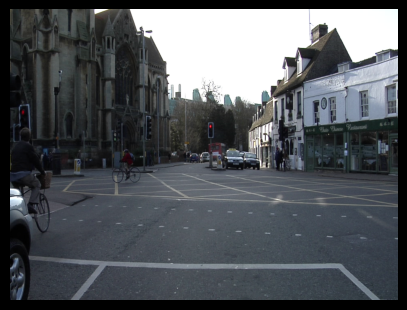

In [3]:

img_fn = fnames[10]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))


<AxesSubplot:>

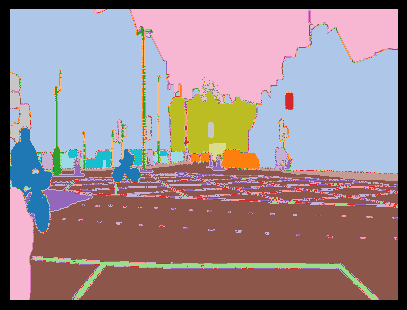

In [4]:

get_msk = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}'

msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)


In [5]:

tensor(msk)

codes = np.loadtxt(path/'codes.txt', dtype=str); codes

def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

sz = msk.shape; sz

half = tuple(int(x/2) for x in sz); half


(360, 480)

In [6]:

camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])


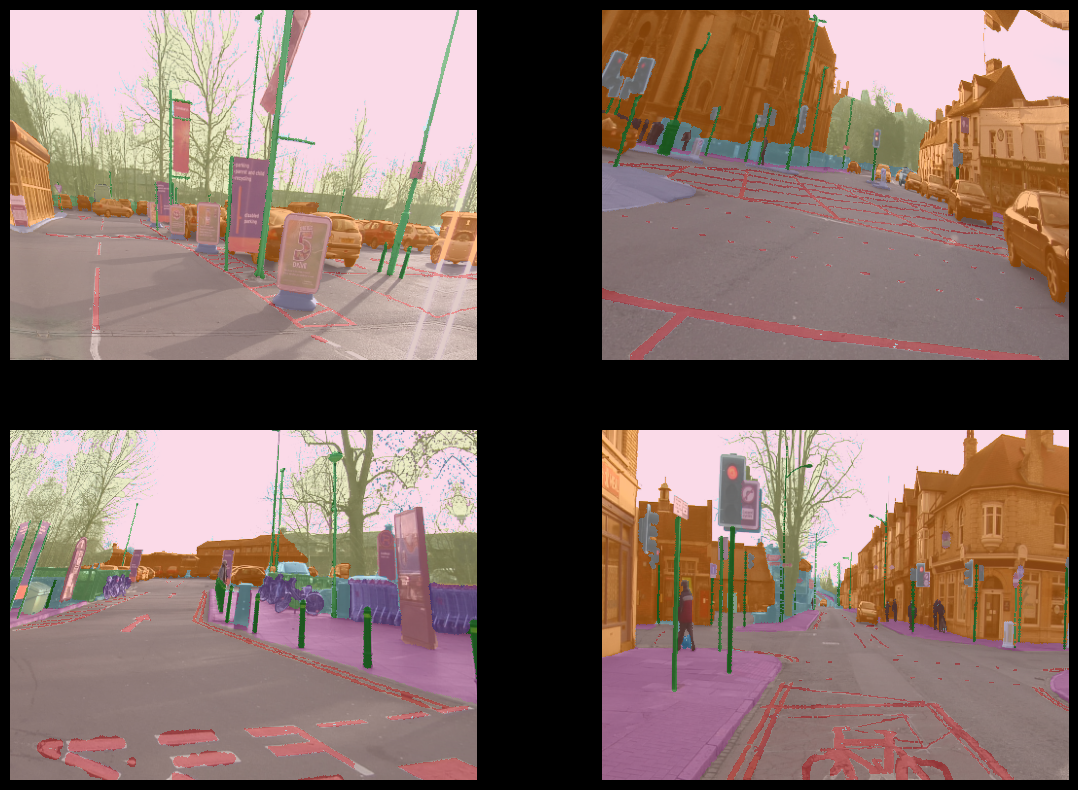

In [7]:

dls = camvid.dataloaders(path/'images', bs=8)
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))
dls.vocab = codes


In [8]:
batch = dls.one_batch()
print(f"length: {len(batch)}")
print(f"type(batch): {type(batch)}")
print(f"batch[0].shape: {dls.one_batch()[0].shape}")
print(f"batch[1].shape: {dls.one_batch()[1].shape}")
print(f"type(batch[0])): {type(batch[0])}")
print(f"type(batch[1])): {type(batch[1])}")
print(f"dls.device: {dls.device}")
print(f"dls.types: {dls.types}")
print(f"dls.input_types: {dls.input_types}")
print(f"dls.dataset: {dls.dataset}")
print(f"dls.train_ds: {dls.train_ds}")


length: 2
type(batch): <class 'tuple'>
batch[0].shape: (8, 3, 360, 480)
batch[1].shape: (8, 360, 480)
type(batch[0])): <class 'fastai.torch_core.TensorImage'>
type(batch[1])): <class 'fastai.torch_core.TensorMask'>
dls.device: cuda:0
dls.types: [[<class 'pathlib.PosixPath'>, (<class 'pathlib.Path'>, <class 'str'>, <class 'torch.Tensor'>, <class 'numpy.ndarray'>, <class 'bytes'>), <class 'fastai.vision.core.PILImage'>], [<class 'pathlib.PosixPath'>, (<class 'pathlib.Path'>, <class 'str'>, <class 'torch.Tensor'>, <class 'numpy.ndarray'>, <class 'bytes'>), <class 'fastai.vision.core.PILMask'>]]
dls.input_types: [(<class 'pathlib.Path'>, <class 'str'>, <class 'torch.Tensor'>, <class 'numpy.ndarray'>, <class 'bytes'>), (<class 'pathlib.Path'>, <class 'str'>, <class 'torch.Tensor'>, <class 'numpy.ndarray'>, <class 'bytes'>)]
dls.dataset: (#600) [(PILImage mode=RGB size=960x720, PILMask mode=L size=960x720),(PILImage mode=RGB size=960x720, PILMask mode=L size=960x720),(PILImage mode=RGB size=

In [9]:

name2id = {v:k for k,v in enumerate(codes)}
name2id

void_code = name2id['Void']


In [10]:

def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

opt = ranger


In [11]:

learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish,  opt_func=opt)

In [12]:

learn.summary()


DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [13]:
inp, pred, target = learn.get_preds(with_input = True)

: 

: 

In [ ]:

learn.lr_find()


In [ ]:
dls.show_batch(figsize=(5,5))